# 사용 데이터 
- S-DOT 2분단위 환경정보
- 기상 관측정보(일사량)
- 태양광 발전량 300 * 일사량 -> 꼭 라벨링 안되어 있어도 됨 같은 값만 아니면 됨 
- XGBClassifier로 속성들 중 중요도 알 수 있음 


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

path = '/content/drive/MyDrive/Colab/SeoulBigData/XGBoost_Logistic_regression'
s_dot = pd.read_csv(path + "/s_dot2.csv", encoding= 'euc-kr')
population = pd.read_csv(path + "/population.csv")
s_dot_bigcam = pd.read_csv(path + "/s_dot_2min.csv")
weather_per_min = pd.read_csv(path + "/weather_per_min.csv")
weather_real_time = pd.read_csv(path + "/weather_real_time.csv")
# ilsa = pd.read_csv(path + "/ilsa.csv", encoding='euc-kr')

In [3]:
weather_per_min.drop(['SECTIME(년월일시분)','S00A(풍향)','S00A_S(풍향)','S01A(풍속)','S02A(기온)','S03M(강수)','S04A(강수유무)','S05A(습도)','S07M(일조)'], axis='columns', inplace=True)

In [4]:
weather_per_min.head()

,SCAPTION(지점명),S06M(일사)
0,[서] 도봉,0
1,[서] 도봉,0
2,[서] 도봉,0
3,[서] 도봉,0
4,[서] 도봉,0


In [5]:
s_dot_bigcam.columns

Index(['MODEL(모델명)', 'SERIAL(시리얼)', 'PM25(초미세먼지)', 'PM10(미세먼지)', 'TEMP(기온)',
       'HUMI(상대습도)', 'WIND_DIRE(풍향)', 'WIND_SPEED(풍속)', 'GUST_DIRE(돌풍 풍향)',
       'GUST_SPEED(돌풍 풍속)', 'INTE_ILLU(조도)', 'ULTRA_RAYS(자외선)', 'NOISE(소음)',
       'VIBR_X(진동x)', 'VIBR_Y(진동y)', 'VIBR_Z(진동z)', 'VIBR_X_MAX(진동x 최대)',
       'VIBR_Y_MAX(진동y 최대)', 'VIBR_Z_MAX(진동z 최대)', 'EFFE_TEMP(흑구 온도)',
       'PM25_STD(초미세먼지 보정)', 'PM10_STD(미세먼지 보정)', 'REG_DATE(측정시간)',
       'CARBON_MONO(일산화탄소)', 'NITROGEN_DIO(이산화질소)', 'SULFUR_DIO(이산화황)',
       'AMMONIA(암모니아)', 'HYDROGEN_SULF(황화수소)', 'OZONE(오존)', 'DB_DATE(등록일시)'],
      dtype='object')

In [6]:
s_dot_bigcam.drop(['MODEL(모델명)','HUMI(상대습도)', 'WIND_DIRE(풍향)', 'WIND_SPEED(풍속)', 'GUST_DIRE(돌풍 풍향)',
       'GUST_SPEED(돌풍 풍속)','ULTRA_RAYS(자외선)', 'NOISE(소음)',
       'VIBR_X(진동x)', 'VIBR_Y(진동y)', 'VIBR_Z(진동z)', 'VIBR_X_MAX(진동x 최대)',
       'VIBR_Y_MAX(진동y 최대)', 'VIBR_Z_MAX(진동z 최대)','CARBON_MONO(일산화탄소)', 'NITROGEN_DIO(이산화질소)', 'SULFUR_DIO(이산화황)',
       'AMMONIA(암모니아)', 'HYDROGEN_SULF(황화수소)', 'OZONE(오존)', 'DB_DATE(등록일시)' ], axis='columns', inplace=True)

In [7]:
s_dot.drop(['기관 명', '송신 서버 번호', '데이터 번호', '모델명', '구분', '초미세먼지(㎍/㎥)',
       '미세먼지(㎍/㎥)', '기온(℃)', '상대습도( %)', '풍향(°)', '풍속(m/s)', '돌풍 풍향(°)',
       '돌풍 풍속(m/s)', '조도(lux)'], axis='columns', inplace=True)

In [8]:

s_dot.drop(['소음(dB)', '진동_x(g)', '진동_y(g)',
       '진동_z(g)', '진동_x 최대(g)', '진동_y 최대(g)', '진동_z 최대(g)', '흑구 운도(℃)',
       '초미세먼지 보정(㎍/㎥)', '미세먼지 보정(㎍/㎥)', '전송시간', ], axis='columns', inplace=True)

In [9]:
# 추가적인 칼럼 수정
s_dot_bigcam.rename(columns = {'SERIAL(시리얼)':'시리얼'}, inplace = True)

In [10]:
# 같은것 모음
s_dot_location_group = s_dot.groupby('시리얼').sum()

In [11]:
s_dot_bigcam_group = s_dot_bigcam.groupby('시리얼').sum()

In [12]:
# 수정후 s_dot_location와 merge
s_dot_bigcam_group_merge = s_dot_bigcam_group.merge(s_dot_location_group,left_on='시리얼',right_on='시리얼')

In [13]:
s_dot_bigcam_group_merge.head()

,PM25(초미세먼지),PM10(미세먼지),TEMP(기온),INTE_ILLU(조도),EFFE_TEMP(흑구 온도),PM25_STD(초미세먼지 보정),PM10_STD(미세먼지 보정),REG_DATE(측정시간),자외선(UVI)
시리얼,,,,,,,,,
OC3CL200011,999.0,999.0,99.9,0.0,99.9,999.0,999.0,202103010001,1.3
OC3CL200012,999.0,999.0,99.9,0.0,99.9,999.0,999.0,202103010000,0.0
OC3CL200013,999.0,999.0,99.9,0.0,99.9,999.0,999.0,202103010001,0.0
OC3CL200014,999.0,999.0,99.9,0.0,99.9,999.0,999.0,202103010000,1.3
OC3CL200016,999.0,999.0,99.9,0.0,99.9,999.0,999.0,202103010000,0.0


In [14]:
# 추가데이터 불러와서 위치정보 로드하기
s_dot_location = pd.read_csv(path + "/S-DoT-locationm.csv", encoding= 'euc-kr')

In [15]:
s_dot_location.drop(['Unnamed: 5','Unnamed: 6',
       'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11',
       'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15',
       'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19',
       'Unnamed: 20', 'Unnamed: 21', 'Unnamed: 22'], axis='columns', inplace=True)

In [16]:
# 추가적인 칼럼 수정
s_dot_location.rename(columns = {'시리얼번호':'시리얼'}, inplace = True)

In [17]:
# 같은것 모음
s_dot_location_group = s_dot_location.groupby('시리얼').sum()

In [18]:
# 수정후 s_dot_location와 merge
s_dot_complete =s_dot_bigcam_group_merge.merge(s_dot_location_group,left_on='시리얼',right_on='시리얼')

In [19]:
s_dot_complete.head()

,PM25(초미세먼지),PM10(미세먼지),TEMP(기온),INTE_ILLU(조도),EFFE_TEMP(흑구 온도),PM25_STD(초미세먼지 보정),PM10_STD(미세먼지 보정),REG_DATE(측정시간),자외선(UVI),위도,경도
시리얼,,,,,,,,,,,
OC3CL200011,999.0,999.0,99.9,0.0,99.9,999.0,999.0,202103010001,1.3,37.422013,127.024266
OC3CL200012,999.0,999.0,99.9,0.0,99.9,999.0,999.0,202103010000,0.0,37.544002,127.069731
OC3CL200013,999.0,999.0,99.9,0.0,99.9,999.0,999.0,202103010001,0.0,37.583469,126.982622
OC3CL200014,999.0,999.0,99.9,0.0,99.9,999.0,999.0,202103010000,1.3,37.563574,126.984504
OC3CL200016,999.0,999.0,99.9,0.0,99.9,999.0,999.0,202103010000,0.0,37.525889,127.039126


In [27]:
ilsa = weather_per_min[:988]
sun1 = ilsa['S06M(일사)'][:100] + 20
sun2 = ilsa['S06M(일사)'][100:140] + 10
sun3 = ilsa['S06M(일사)'][140:] + 5
sun_ = pd.concat([sun1, sun2])
_sun = pd.concat([sun_, sun3])
print(len(_sun))

df = pd.DataFrame({
    'pm25': s_dot_complete['PM25(초미세먼지)'].values,
    'pm10': s_dot_complete['PM10(미세먼지)'].values,
    'temp': s_dot_complete['TEMP(기온)'].values,
    'ilsa': ilsa['S06M(일사)'].values,
    'uvi': s_dot_complete['자외선(UVI)'].values,
    'effe_temp': s_dot_complete['EFFE_TEMP(흑구 온도)'].values,
    'sun': _sun.values
})


988


In [44]:
sun_avg = np.mean(df['sun'].values)
label = []
for i in df['sun'].values:
  if i > sun_avg:
    label.append(1)
  else:
    label.append(0)
df['label'] = label
df['label'].value_counts()

0    848
1    140
Name: label, dtype: int64

In [45]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

X_t = df[['pm25', 'pm10', 'temp', 'ilsa', 'uvi', 'effe_temp']]
Y_t = df['label']

In [46]:
scaler = StandardScaler()
scaler.fit(X_t)
X_scaled = scaler.transform(X_t)
X_scaled = pd.DataFrame(data=X_scaled, index=X_t.index, columns=X_t.columns)
X_scaled.columns

Index(['pm25', 'pm10', 'temp', 'ilsa', 'uvi', 'effe_temp'], dtype='object')

In [47]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y_t, test_size=0.3, random_state=1)

In [48]:
from xgboost import XGBClassifier

# XGBClassifier 모델 생성/학습
model_xgb = XGBClassifier()
model_xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [49]:
model_xgb.feature_importances_

array([0.06229506, 0.        , 0.        , 0.        , 0.9224552 ,
       0.01524974], dtype=float32)

In [50]:
# Predict를 수행하고 classification_report() 결과 출력하기
pred = model_xgb.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.85      1.00      0.92       252
           1       1.00      0.02      0.04        45

    accuracy                           0.85       297
   macro avg       0.93      0.51      0.48       297
weighted avg       0.87      0.85      0.79       297



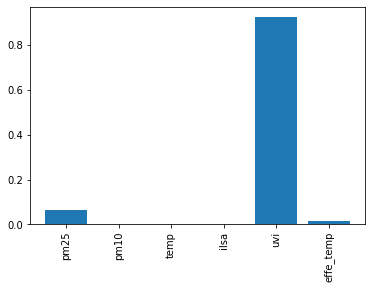

In [51]:
# # 이거는 데이터 받아서 다시 돌려보고 안되면 다른 블로그 보고 짜넣기 
from sklearn.metrics import plot_precision_recall_curve

plt.bar(X_scaled.columns, model_xgb.feature_importances_)
plt.xticks(rotation=90)
plt.show()
# from xgboost import plot_importance
# import matplotlib.pyplot as plt
# %matplotlib inline

# fig, ax = plt.subplots(figsize=(10, 12))
# # 사이킷런 래퍼 클래스를 입력해도 무방. 
# plot_importance(xgb_wrapper, ax=ax)

In [52]:
from sklearn.linear_model import LogisticRegression

# LogisticRegression 모델 생성/학습
model_lr = LogisticRegression(max_iter=1000)
model_lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

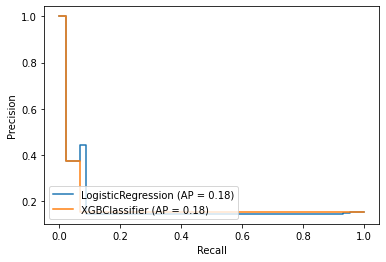

In [53]:
from sklearn.metrics import plot_precision_recall_curve

# 두 모델의 Precision-Recall 커브를 한번에 그리기 (힌트: fig.gca()로 ax를 반환받아 사용)
fig = plt.figure()
ax = fig.gca()
plot_precision_recall_curve(model_lr, X_test, y_test, ax=ax)
plot_precision_recall_curve(model_xgb, X_test, y_test, ax=ax)